In [2]:
import numpy as np
import json

from ANT_utils import *

# 1) Load Data

In [3]:
L_fixed = ['exchange_rate_nips','solar_nips','traffic_nips','wiki2000_nips']
L_variable = ['uber_tlc_hourly', 'electricity_nips', 'kdd_cup_2018_without_missing', 'm4_hourly']

In [10]:
DATASET = 'exchange_rate_nips'
PATH = f'../.mxnet/gluon-ts/datasets/{DATASET}/train/data.json'
TS, _ = read_json(PATH)

# 2) Define scheduler

In [11]:
scheduler = 'cosine'
T = 50
tau = 0.5

In [12]:
betas = return_betas(scheduler, tau, T, beta_0 = 0.0001, beta_T = 0.1)

# 3) ANT score

## 3-1) Autocorrelation

In [13]:
out = get_scheduler_utils(T,betas)
sqrt_one_minus_beta, alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, posterior_variance = out

TS_acf = []
for ts in TS:
    ts = preprocess_data(ts)
    acf = return_acf(ts, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,T)
    TS_acf.append(acf)

In [14]:
if DATASET in L_variable:
    TS_acf = pad_acf_data(TS_acf)
else:
    TS_acf = np.array(TS_acf)
    
non_nan_index = np.where(np.isnan(TS_acf[:,0,:]).sum(axis=1)==0)
TS_acf = TS_acf[non_nan_index]    

In [15]:
N,T,L = TS_acf.shape
print(f'[N] # of TS: {N}')
print(f'[T] # of Diffusion Steps: {T}')
print(f'[L] Length of TS: {L}')

[N] # of TS: 8
[T] # of Diffusion Steps: 50
[L] Length of TS: 6071


## 3-2) Non-stationarity curve
- statistics: `IAAT`

In [16]:
IAAT, scaled_IAAT = get_IAAT_list(TS_acf)

## 3-3) ANT score

In [17]:
ANT_score = calculate_ANT_score(IAAT, scaled_IAAT)
ANT_score

0.07410087554546865

# 4) Visualization

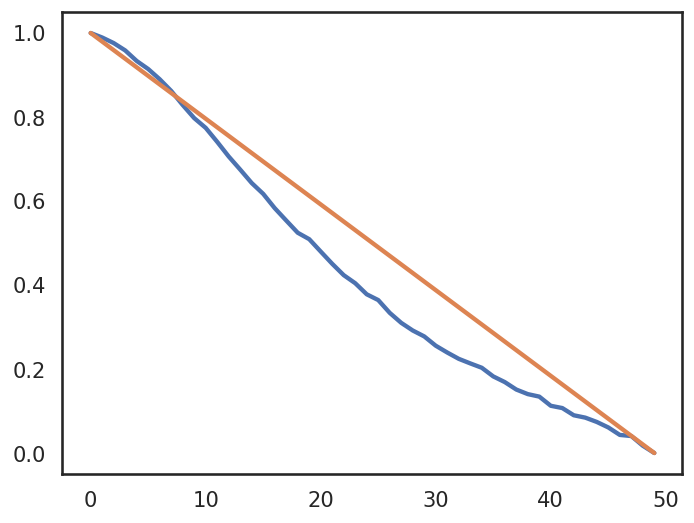

In [18]:
plt.plot(scaled_IAAT)
plt.plot(np.linspace(1,0,len(scaled_IAAT)))